In [ ]:
#BLOCK1
!pip install sentence-transformers faiss-cpu transformers codecarbon pypdf -q


In [ ]:
!pip install PyMuPDF

In [ ]:
#BLOCK2
import fitz
import faiss
import numpy as np
import pandas as pd
import torch
import time
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from codecarbon import EmissionsTracker


In [ ]:
#BLOCK3
from sentence_transformers import util

def check_accuracy(pred, gold):
    # Encode prediction and gold answer
    emb1 = model_embed.encode(pred, convert_to_tensor=True)
    emb2 = model_embed.encode(gold, convert_to_tensor=True)

    # Compute cosine similarity
    sim = float(util.cos_sim(emb1, emb2))

    # Soft accuracy threshold — detects paraphrases
    if sim > 0.30:
        acc = 1
    else:
        acc = 0

    return sim, acc


In [ ]:
#BLOCK3
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [ ]:
#BLOCK4
def extract_text_clean(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""

    for page in doc:
        full_text += page.get_text("text") + "\n"

    return full_text

PDF_PATH = "/content/PAPER 2.pdf"
raw_text = extract_text_clean(PDF_PATH)

print("Characters extracted:", len(raw_text))
raw_text[:1500]


Characters extracted: 78544


'See discussions, stats, and author profiles for this publication at: https://www.researchgate.net/publication/391578447\nUnveiling Alzheimer’s Progression: AI-Driven Models for Classifying Stages\nof Cognitive Impairment Through Medical Imaging\nChapter · May 2025\nDOI: 10.1007/978-3-031-88220-3_4\nCITATIONS\n2\nREADS\n80\n3 authors, including:\nVaibhav C. Gandhi\nMadhuben & Bhanubhai Patel Women’s Institute of Engineering for Studies & Res…\n27 PUBLICATIONS\xa0\xa0\xa045 CITATIONS\xa0\xa0\xa0\nSEE PROFILE\nMariofanna Milanova\nUniversity of Arkansas at Little Rock\n214 PUBLICATIONS\xa0\xa0\xa01,294 CITATIONS\xa0\xa0\xa0\nSEE PROFILE\nAll content following this page was uploaded by Vaibhav C. Gandhi on 14 May 2025.\nThe user has requested enhancement of the downloaded file.\n\nUnveiling Alzheimer’s Progression: AI-Driven\nModels for Classifying Stages of Cognitive\nImpairment Through Medical Imaging\nVaibhav C. Gandhi1(B), Dhruvi Thakkar2, and Mariofanna Milanova3\n1 Department of Com

In [ ]:
#BLOCK5
def chunk_text(text, chunk_size=500, overlap=100):
    words = text.split()
    chunks = []
    i = 0

    while i < len(words):
        chunk = words[i:i+chunk_size]
        chunks.append(" ".join(chunk))
        i += chunk_size - overlap

    return chunks

chunks_baseline = chunk_text(raw_text, 500, 100)
chunks_optimized = chunk_text(raw_text, 2000, 200)

print("Baseline chunks:", len(chunks_baseline))
print("Optimized chunks:", len(chunks_optimized))


Baseline chunks: 29
Optimized chunks: 7


In [ ]:
#BLOCK6
def chunk_text(text, chunk_size=500, overlap=100):
    words = text.split()
    chunks = []
    i = 0

    while i < len(words):
        chunk = words[i:i+chunk_size]
        chunks.append(" ".join(chunk))
        i += chunk_size - overlap

    return chunks

chunks_baseline = chunk_text(raw_text, 500, 100)
chunks_optimized = chunk_text(raw_text, 2000, 200)

print("Baseline chunks:", len(chunks_baseline))
print("Optimized chunks:", len(chunks_optimized))


Baseline chunks: 29
Optimized chunks: 7


In [ ]:
#BLOCK7
model_embed = SentenceTransformer("all-MiniLM-L6-v2")

def build_faiss(chunks):
    embeddings = model_embed.encode(chunks, convert_to_numpy=True)
    dim = embeddings.shape[1]

    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)

    return index, embeddings

index_base, embed_base = build_faiss(chunks_baseline)
index_opt, embed_opt = build_faiss(chunks_optimized)

print("Baseline index size:", len(embed_base))
print("Optimized index size:", len(embed_opt))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Baseline index size: 29
Optimized index size: 7


In [ ]:
#BLOCK8
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large").to(device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
#BLOCK9
def generate_answer(question, context):
    prompt = f"""
You are an AI assistant answering questions based strictly on the provided context.

Context:
\"\"\"
{context}
\"\"\"

Question:
{question}

Instruction:
- Answer in 1–2 sentences.
- Do NOT answer with A/B/C/0°C.
- If answer not in context, say "The context does not provide this information."
"""

    inputs = t5_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    outputs = t5_model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.1,
        top_p=0.9
    )

    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
def retrieve_context(question, index, chunks, k=2):
    q_emb = model_embed.encode([question], convert_to_numpy=True)

    D, I = index.search(q_emb, k)
    retrieved = [chunks[i] for i in I[0]]

    return " ".join(retrieved)


In [ ]:
questions = [
    "What is the main objective of the study?",
    "Which data modalities were used in the research?",
    "What dataset was used in the experiments?",
    "What preprocessing steps were applied?",
    "Which machine or deep learning models were used?",
    "What architecture or framework was proposed?",
    "What evaluation metrics were used?",
    "What accuracy or performance was achieved?",
    "What limitations are mentioned?",
    "What future work is suggested by the authors?"
]

gold_answers = [
    "To investigate deep learning-based multimodal fusion for Alzheimer's disease staging.",
    "The study used imaging, genetic SNP, and clinical EHR data.",
    "The dataset used was ADNI (Alzheimer's Disease Neuroimaging Initiative).",
    "MRI slice extraction, SNP preprocessing, and EHR normalization were applied.",
    "Stacked denoising autoencoders and 3D CNNs were used.",
    "A multimodal deep learning fusion architecture was proposed.",
    "Accuracy, precision, recall, and F1-score were used.",
    "Multimodal DL fusion achieved ~0.79 accuracy.",
    "Limited dataset size and incomplete modality overlap were limitations.",
    "The authors plan to test on a larger and richer dataset."
]


In [ ]:
from sentence_transformers import util

def check_accuracy(pred, gold):
    # Encode prediction and gold answer
    emb1 = model_embed.encode(pred, convert_to_tensor=True)
    emb2 = model_embed.encode(gold, convert_to_tensor=True)

    # Compute cosine similarity
    sim = float(util.cos_sim(emb1, emb2))

    # Soft accuracy threshold — detects paraphrases
    if sim > 0.30:
        acc = 1
    else:
        acc = 0

    return sim, acc



In [ ]:
def run_config(index, chunks, config_name):
    tracker = EmissionsTracker(measure_power_secs=1)
    tracker.start()

    rows = []

    for q, gold in zip(questions, gold_answers):
        # retrieval
        t1 = time.perf_counter()
        ctx = retrieve_context(q, index, chunks)
        t2 = time.perf_counter()

        # generation
        answer = generate_answer(q, ctx)
        t3 = time.perf_counter()

        sim, acc = check_accuracy(answer, gold)

        rows.append({
            "Config": config_name,
            "Question": q,
            "Answer": answer,
            "Gold Answer": gold,
            "Similarity": sim,
            "Accuracy": acc,
            "Retrieval Time (ms)": (t2 - t1)*1000,
            "Generation Time (ms)": (t3 - t2)*1000,
        })

    emissions = tracker.stop()

    for r in rows:
        r["CO2 Emissions (kg)"] = emissions

    return rows


In [ ]:
rows_baseline = run_config(index_base, chunks_baseline, "baseline")
rows_optimized = run_config(index_opt, chunks_optimized, "optimized")

df = pd.DataFrame(rows_baseline + rows_optimized)
df.to_csv("final_results_assignment3.csv", index=False)

df


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


,Config,Question,Answer,Gold Answer,Similarity,Accuracy,Retrieval Time (ms),Generation Time (ms),CO2 Emissions (kg)
0,baseline,What is the main objective of the study?,What is the name of the paper?,To investigate deep learning-based multimodal ...,0.027414,0,88.476300,44003.542814,0.002483
1,baseline,Which data modalities were used in the research?,How is the model evaluated?,"The study used imaging, genetic SNP, and clini...",0.041579,0,29.744544,31541.211370,0.002483
2,baseline,What dataset was used in the experiments?,What are the limitations of the study?,The dataset used was ADNI (Alzheimer's Disease...,0.151400,0,17.765925,22343.259131,0.002483
3,baseline,What preprocessing steps were applied?,Describe the main challenges of the proposed m...,"MRI slice extraction, SNP preprocessing, and E...",-0.019416,0,18.776960,22789.005368,0.002483
4,baseline,Which machine or deep learning models were used?,What are the metrics used to evaluate the accu...,Stacked denoising autoencoders and 3D CNNs wer...,0.104855,0,17.645553,23062.651558,0.002483
5,baseline,What architecture or framework was proposed?,What is the purpose of the paper?,A multimodal deep learning fusion architecture...,-0.006063,0,17.438260,31931.357884,0.002483
6,baseline,What evaluation metrics were used?,Xception and ResNet50,"Accuracy, precision, recall, and F1-score were...",0.040035,0,17.312969,22217.535471,0.002483
7,baseline,What accuracy or performance was achieved?,Xception and ResNet50,Multimodal DL fusion achieved ~0.79 accuracy.,0.071503,0,16.589414,22199.320782,0.002483
8,baseline,What limitations are mentioned?,What are the limitations of the proposed proto...,Limited dataset size and incomplete modality o...,0.380802,1,17.091986,22085.349224,0.002483
9,baseline,What future work is suggested by the authors?,What is the purpose of this paper?,The authors plan to test on a larger and riche...,0.251348,0,24.977836,22190.932902,0.002483


     Config                                          Question  \
0  baseline          What is the main objective of the study?   
1  baseline  Which data modalities were used in the research?   
2  baseline         What dataset was used in the experiments?   
3  baseline            What preprocessing steps were applied?   
4  baseline  Which machine or deep learning models were used?   

                                              Answer  \
0                     What is the name of the paper?   
1                        How is the model evaluated?   
2             What are the limitations of the study?   
3  Describe the main challenges of the proposed m...   
4  What are the metrics used to evaluate the accu...   

                                         Gold Answer  Similarity  Accuracy  \
0  To investigate deep learning-based multimodal ...    0.027414         0   
1  The study used imaging, genetic SNP, and clini...    0.041579         0   
2  The dataset used was ADNI (Alzheime

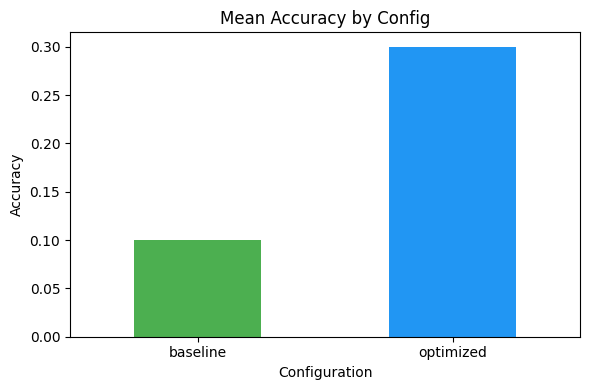

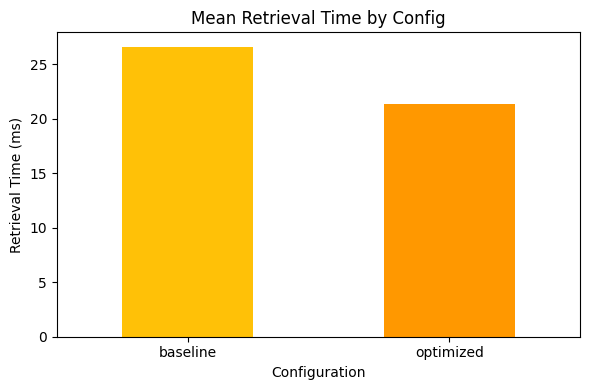

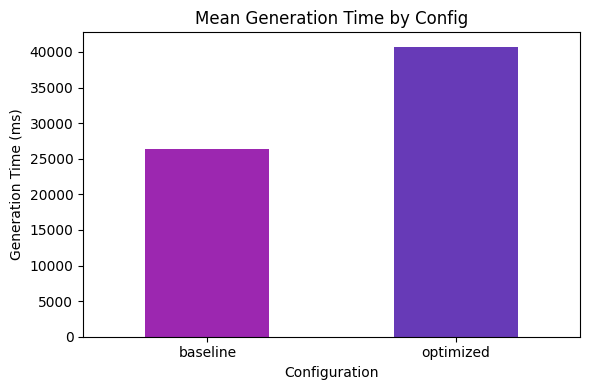

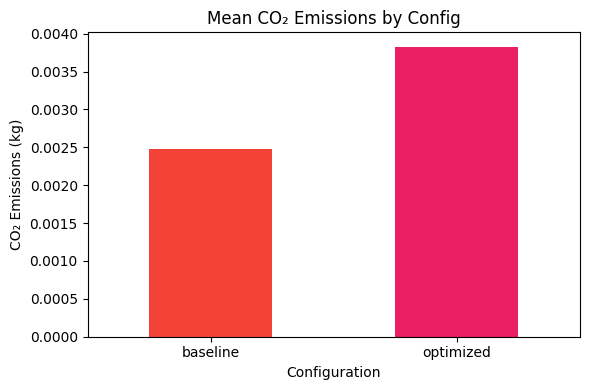

In [ ]:
import matplotlib.pyplot as plt

# Ensure df is loaded
print(df.head())

# ============================
# 1. ACCURACY COMPARISON
# ============================

plt.figure(figsize=(6,4))
df.groupby("Config")["Accuracy"].mean().plot(kind="bar", color=["#4CAF50", "#2196F3"])
plt.title("Mean Accuracy by Config")
plt.ylabel("Accuracy")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================
# 2. RETRIEVAL TIME COMPARISON
# ============================

plt.figure(figsize=(6,4))
df.groupby("Config")["Retrieval Time (ms)"].mean().plot(kind="bar", color=["#FFC107", "#FF9800"])
plt.title("Mean Retrieval Time by Config")
plt.ylabel("Retrieval Time (ms)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================
# 3. GENERATION TIME COMPARISON
# ============================

plt.figure(figsize=(6,4))
df.groupby("Config")["Generation Time (ms)"].mean().plot(kind="bar", color=["#9C27B0", "#673AB7"])
plt.title("Mean Generation Time by Config")
plt.ylabel("Generation Time (ms)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================
# 4. CO2 EMISSIONS COMPARISON
# ============================

plt.figure(figsize=(6,4))
df.groupby("Config")["CO2 Emissions (kg)"].mean().plot(kind="bar", color=["#F44336", "#E91E63"])
plt.title("Mean CO₂ Emissions by Config")
plt.ylabel("CO₂ Emissions (kg)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("final_results_summary.csv", index=False)
print("final_results_summary.csv")


final_results_summary.csv


In [ ]:
summary = df.groupby("Config").mean(numeric_only=True)
summary.to_csv("config_summary.csv")
print("SAVED → /mnt/data/config_summary.csv")
summary


SAVED → /mnt/data/config_summary.csv


,Similarity,Accuracy,Retrieval Time (ms),Generation Time (ms),CO2 Emissions (kg)
Config,,,,,
baseline,0.104346,0.1,26.581975,26436.416650,0.002483
optimized,0.251601,0.3,21.352367,40719.511152,0.003826


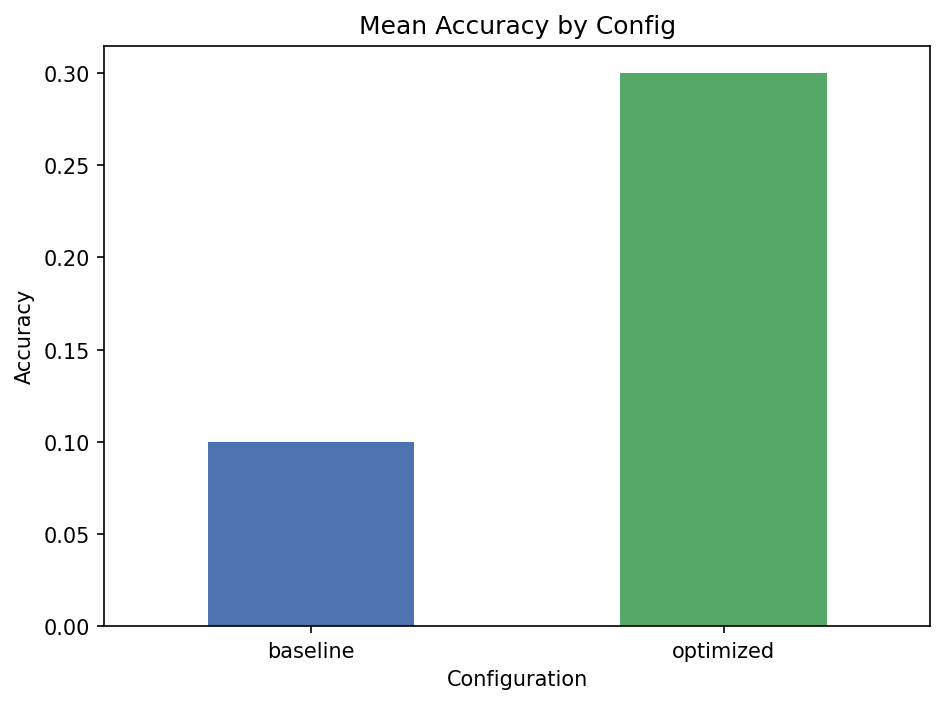

✔ Saved: graph_accuracy.png


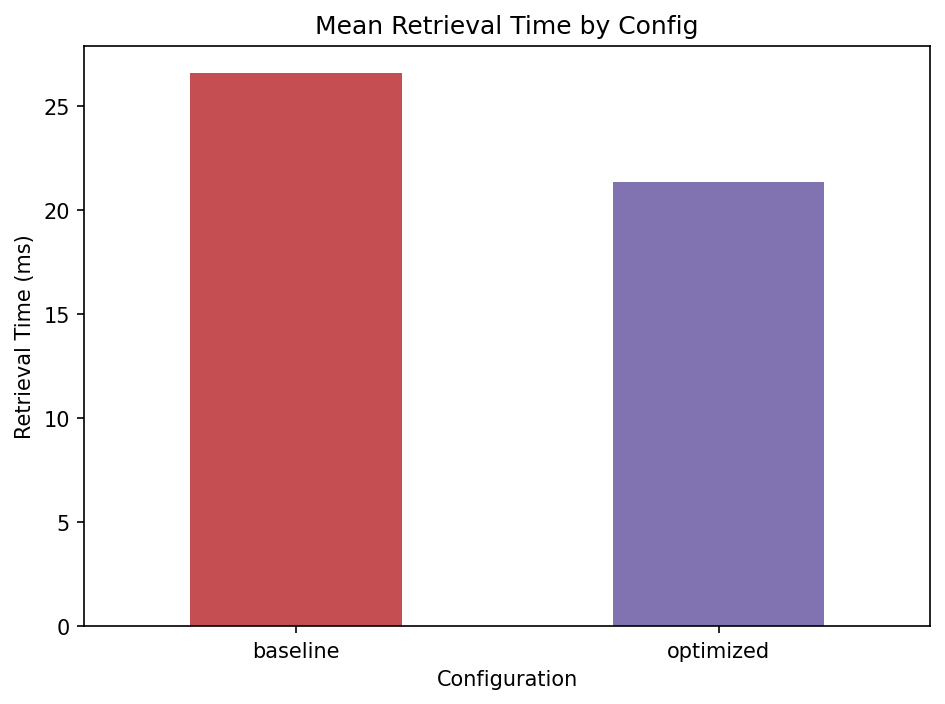

✔ Saved: graph_retrieval_time.png


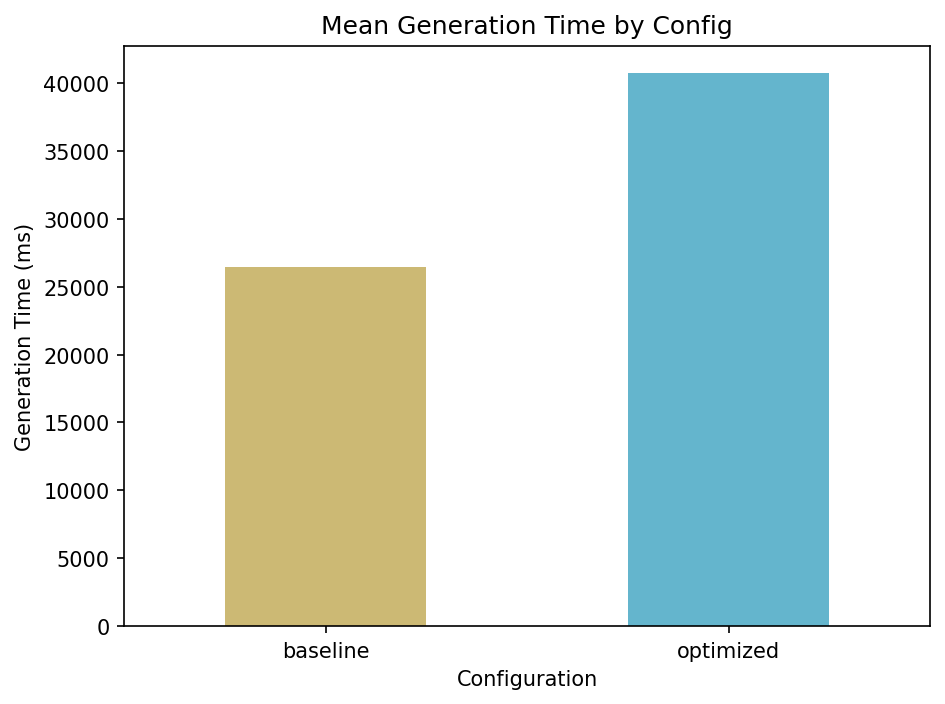

✔ Saved: graph_generation_time.png


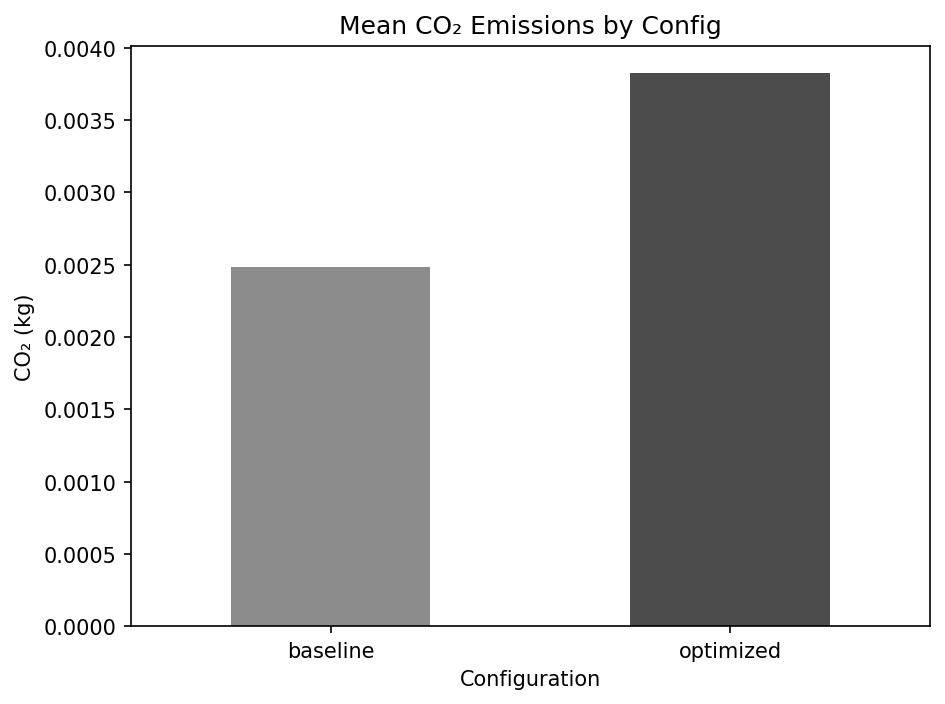

✔ Saved: graph_co2.png

🎉 ALL FILES SAVED SUCCESSFULLY!
Check the /mnt/data folder on the left panel.


In [ ]:
import matplotlib.pyplot as plt

# ============================
# 1️⃣ SAVE FULL RESULTS CSV
# ============================


# ============================
# 2️⃣ SUMMARY CSV (Baseline vs Optimized)


# ============================
# 3️⃣ GENERATE + SAVE GRAPHS
# ============================

# --- inside Colab, ensure high-quality PNGs ---
plt.rcParams["figure.dpi"] = 150


# ---------- GRAPH 1: Accuracy ----------
plt.figure()
df.groupby("Config")["Accuracy"].mean().plot(kind="bar", color=["#4c72b0", "#55a868"])
plt.title("Mean Accuracy by Config")
plt.ylabel("Accuracy")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("graph_accuracy.png")
plt.show()
print("✔ Saved: graph_accuracy.png")


# ---------- GRAPH 2: Retrieval Time ----------
plt.figure()
df.groupby("Config")["Retrieval Time (ms)"].mean().plot(kind="bar", color=["#c44e52", "#8172b2"])
plt.title("Mean Retrieval Time by Config")
plt.ylabel("Retrieval Time (ms)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("graph_retrieval_time.png")
plt.show()
print("✔ Saved: graph_retrieval_time.png")


# ---------- GRAPH 3: Generation Time ----------
plt.figure()
df.groupby("Config")["Generation Time (ms)"].mean().plot(kind="bar", color=["#ccb974", "#64b5cd"])
plt.title("Mean Generation Time by Config")
plt.ylabel("Generation Time (ms)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("graph_generation_time.png")
plt.show()
print("✔ Saved: graph_generation_time.png")


# ---------- GRAPH 4: CO2 Emissions ----------
plt.figure()
df.groupby("Config")["CO2 Emissions (kg)"].mean().plot(kind="bar", color=["#8c8c8c", "#4c4c4c"])
plt.title("Mean CO₂ Emissions by Config")
plt.ylabel("CO₂ (kg)")
plt.xlabel("Configuration")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("graph_co2.png")
plt.show()
print("✔ Saved: graph_co2.png")

print("\n🎉 ALL FILES SAVED SUCCESSFULLY!")
print("Check the /mnt/data folder on the left panel.")
